# Generating data tutorial

This tutorial is a simplified version of our Write a [STAR file of simulated data](https://mjo22.github.io/cryojax/examples/simulate-relion-dataset/) tutorial.

In [1]:
# regular imports
import matplotlib.pyplot as plt
from functools import partial


# Jax imports
import jax
import jax.numpy as jnp
import equinox as eqx
from jaxtyping import PRNGKeyArray, Float, Array, Int


# cryoJAX's imports
import cryojax as cx
import cryojax.simulator as cxs
from cryojax.io import read_atoms_from_pdb

# 1. Generating a STAR file

First we will generate the parameters for the starfile, such as the relion optics information, as well as the defocus and pose parameters. This will be generated as cryoJAX `RelionParticleParameterFile`.

The following function generates a set of imaging parameters for a single image given a JAX random key (equivalent to a seed). The decorator allows us to generate the imaging parameters for multiple images by passing an array of keys.

In [2]:
@partial(eqx.filter_vmap, in_axes=(0, None))
def make_particle_parameters(
    key: PRNGKeyArray, instrument_config: cxs.InstrumentConfig
):  # -> tuple[RelionParticleParameters, RelionParticleParameters]:
    # Generate random parameters

    # Pose
    # ... instantiate rotations
    key, subkey = jax.random.split(key)  # split the key to use for the next random number
    rotation = cx.rotations.SO3.sample_uniform(subkey)

    # ... now in-plane translation
    ny, nx = instrument_config.shape

    key, subkey = jax.random.split(key)  # do this everytime you use a key!!
    offset_in_angstroms = (
        jax.random.uniform(subkey, (2,), minval=-0.1, maxval=0.1) # covers 40% of the grid
        * jnp.asarray((nx, ny))
        * instrument_config.pixel_size
    )
    # ... build the pose
    pose = cxs.EulerAnglePose.from_rotation_and_translation(rotation, offset_in_angstroms)

    # CTF Parameters
    # ... defocus
    key, subkey = jax.random.split(key)
    defocus_in_angstroms = jax.random.uniform(subkey, (), minval=10000, maxval=15000)

    key, subkey = jax.random.split(key)
    astigmatism_in_angstroms = jax.random.uniform(subkey, (), minval=0, maxval=100)

    key, subkey = jax.random.split(key)
    astigmatism_angle = jax.random.uniform(subkey, (), minval=0, maxval=jnp.pi)

    key, subkey = jax.random.split(key)
    phase_shift = jax.random.uniform(subkey, (), minval=0, maxval=0)
    # no more random numbers needed

    # now generate your non-random values
    spherical_aberration_in_mm = 2.7
    amplitude_contrast_ratio = 0.07

    # ... build the CTF
    transfer_theory = cxs.ContrastTransferTheory(
        ctf=cxs.CTF(
            defocus_in_angstroms=defocus_in_angstroms,
            astigmatism_in_angstroms=astigmatism_in_angstroms,
            astigmatism_angle=astigmatism_angle,
            spherical_aberration_in_mm=spherical_aberration_in_mm,
        ),
        amplitude_contrast_ratio=amplitude_contrast_ratio,
        phase_shift=phase_shift,
    )

    particle_parameters = {
        "instrument_config": instrument_config,
        "pose": pose,
        "transfer_theory": transfer_theory,
        "metadata": {}, # you can add any metadata you want here
    }

    return particle_parameters

The function takes a jax random key and a cryojax `InstrumentConfig`. This object simply has information on the box size, pixel size, and voltage. Additionally, you can set padding to the grid. In that case the images will be generated using the padded shape and then cropped. This can help reduce artifacs caused by in-plane shifts and the CTF.

In [3]:
seed = 0

# Generate instrument config
instrument_config = cxs.InstrumentConfig(
    shape=(128, 128),
    pixel_size=2.0,
    voltage_in_kilovolts=300.0,
    pad_scale=1.0,  # no padding
)

# Generate RNG keys
number_of_images = 1000
keys = jax.random.split(jax.random.key(seed), number_of_images)

particle_parameters = make_particle_parameters(keys, instrument_config)

/mnt/sw/nix/store/29h1dijh98y9ar6n8hxv78v8zz2pqfzf-python-3.11.7-view/lib/python3.11/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/29h1dijh98y9ar6n8hxv78v8zz2pqfzf-python-3.11.7-view/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


Now we can create a new `RelionParticleParameterFile` and add all the imaging parameters we just generated:

In [5]:
# ... generate the starfile
new_parameters_file = cx.data.RelionParticleParameterFile(
    path_to_starfile="./dataset/relion_dataset.star",
    mode="w",  # writing mode!
    exists_ok=True,  # in case the file already exists
)
new_parameters_file.append(particle_parameters)
new_parameters_file.save(overwrite=True)

The starfile currently does not have a `rlnImageName` column, as we have not generated images yet. We will do this in the following step.

# 2. Preparing for image simulation

We will now prepare for simulating the images. This is a short step we will load the atomic model / volume density that we will use to generate the images. In this tutorial we will use an atomic model.

The atomic model to be used is based on chain A of GroEL, which we will refer to as holo GroEL.

In [6]:
from cryojax.constants import get_tabulated_scattering_factor_parameters

atom_positions, atom_identities, b_factors = read_atoms_from_pdb(
    "../atomic_models/holo_groel.pdb", center=True, selection_string="not element H", loads_b_factors=True
)


Our function returns the atomic positions, atom identities (i.e. the atomic number) and the Debye-Waller factors (b-factors) from the pdb. In addition, we center the structure based on its center of mass, and filter all hydrogen atoms.

We will now load the electron scattering factors for all the loaded atoms and define a cryoJAX `Potential`.

In [7]:
scattering_factor_parameters = get_tabulated_scattering_factor_parameters(
    atom_identities=atom_identities,
)

atomic_potential = cxs.PengAtomicPotential(
    atom_positions,
    scattering_factor_a=scattering_factor_parameters["a"],
    scattering_factor_b=scattering_factor_parameters["b"],
    b_factors=b_factors,
)

Now we just need a way to integrate this potential. This is the equivalent of a Fourier Slice extraction when using a volumetric potential

In [8]:
potential_integrator = cxs.GaussianMixtureProjection(
    upsampling_factor=None, # you can set this to compute the projection at a higher resolution
    shape=None, # we will just use the shape of the instrument config
    use_error_functions=False, # better quality, but slower
    n_batches=1, # batch the computation to subsets of atoms, helps with memory management
)

Lastly, we need to define a mask. This will be used to normalize the signal and add noise at a given SNR.

In [9]:
mask = cx.image.operators.CircularCosineMask(
    coordinate_grid=instrument_config.coordinate_grid_in_pixels,
    radius=instrument_config.shape[0] // 2,
    rolloff_width=0.0,
)

# 3. Simulating a dataset

First let's write our image simulation function. CryoJAX requires this function to have a specific format, which allows for more flexibility when defining an image model. A compute image should be defined as `compute_image_fn(parameters, constant_args, per_particle_args)`. The constant args are arguments that will not change between images (e.g., the integrator), while the per particle arguments change betwen images (e.g., random keys, scales, different SNRs). The `parameters` are simply an index of a cryojax `RelionParticleParameterFile`.

In [10]:
from cryojax.inference.distributions import IndependentGaussianPixels

def compute_image_with_noise(parameters, constant_args, per_particle_args):
    potential, potential_integrator, mask, snr = constant_args
    noise_key = per_particle_args  # jax random key

    structural_ensemble = cxs.SingleStructureEnsemble(potential, parameters["pose"])

    scattering_theory = cxs.WeakPhaseScatteringTheory(
        structural_ensemble, potential_integrator, parameters["transfer_theory"]
    )

    image_model = cxs.ContrastImageModel(
        parameters["instrument_config"], scattering_theory, mask=mask
    )

    distribution = IndependentGaussianPixels(
        image_model,
        variance=1.0,
        signal_scale_factor=jnp.sqrt(snr),
        normalizes_signal=True,
    )

    return distribution.sample(noise_key, applies_mask=False)

Let's see an example of an image at high SNR

/mnt/sw/nix/store/29h1dijh98y9ar6n8hxv78v8zz2pqfzf-python-3.11.7-view/lib/python3.11/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/29h1dijh98y9ar6n8hxv78v8zz2pqfzf-python-3.11.7-view/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/29h1dijh98y9ar6n8hxv78v8zz2pqfzf-python-3.11.7-view/lib/python3.11/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/29h1dijh98y9ar6n8hxv78v8zz2pqfzf-python-3.11.7-view/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <clas

(-0.5, 127.5, 127.5, -0.5)

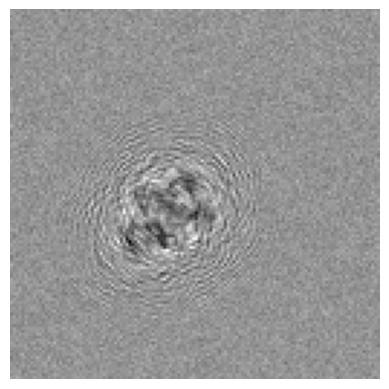

In [11]:
key = jax.random.key(0)

snr = 2.0

image_with_noise = compute_image_with_noise(
    new_parameters_file[0],
    (atomic_potential, potential_integrator, mask, snr),
    key,
)

plt.imshow(image_with_noise, cmap="gray")
plt.axis("off")

Let's now generate a dataset at a lower SNR. First let's create a cryojax `RelionParticleDataset`

In [12]:
path_to_mrc_files = "./dataset/particles/"

particle_dataset = cx.data.RelionParticleStackDataset(
    new_parameters_file,
    path_to_relion_project=path_to_mrc_files,
    mode="w",
    mrcfile_settings={"overwrite": True},  # customize your .mrcs !
)

The following function will use everything we've built so far. It will iterate through the starfile calling our `compute_image_with_noise`, and save the generated images to starfiles. The `particle_dataset` will be updated in-place, and the names for the particles in the starfile will be populated. Let's now generate the dataset and see some of the outputs. Since we saved the starfile previously we will have to set overwrite to `True`.

In [18]:
key = jax.random.key(10232)
noise_keys = jax.random.split(key, number_of_images)
snr = 2.0

cx.data.simulate_particle_stack(
    particle_dataset,
    compute_image_fn=compute_image_with_noise,
    constant_args=(atomic_potential, potential_integrator, mask, snr),
    per_particle_args=noise_keys,
    batch_size=10,  # this is for images generated in parallel
    images_per_file=500, # creates two files with 500 images each
    overwrite=True, # overwrites the starfile!
)

Indexing the `particle_dataset` will give us a dictionary containting the "parameters" and the "images" associated to that row of the starfile. You can also load multiple indices or slices to load multiple images and multiple rows of the starfile.

In [19]:
particle_dataset[0].keys()

dict_keys(['parameters', 'images'])

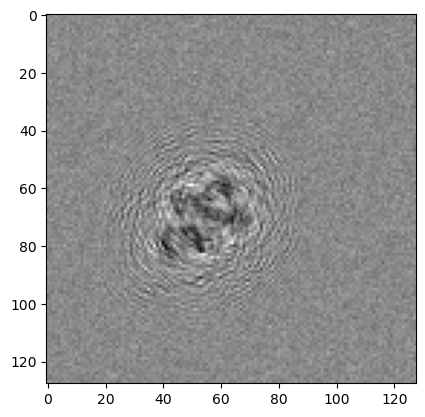

In [20]:
plt.imshow(particle_dataset[0]["images"], cmap="gray")

In [16]:
particle_dataset[0:10]["images"].shape

(10, 128, 128)

Loading using an array of indices is also allowed, but only if the indices are in a numpy array.

In [17]:
import numpy as np

particle_dataset[np.array([0, 3, 6, 2, 10])]["images"].shape

(5, 128, 128)